## Spike sorting demo for BRW files
----

https://gist.github.com/mhhennig/97453faec66ea78f96e61a193f699e6c

**to fix**
- fix the deprecation in the package here
- turn off the pre-filtering for herdingspike
- apply scaling, and then turn it off with herdingspike
- KS2 seems to be best here for the detections --> have not tried KS4, which is the latest available for this

-----

**load libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pathlib
import sys, os

import spikeinterface.full as si
import spikeinterface.preprocessing as st

%matplotlib inline

Set the file path to the raw data, contained within a ```.brw``` file format.

In [2]:
raw_file = pathlib.Path('data', 's2_bs.brw')

# check the file path
if not raw_file.exists():
    print(f'File {raw_file} does not exist')
    sys.exit(1)

Initalized the object.

Files are stored as discrete 64-bit integers.

In [3]:
RX = si.BiocamRecordingExtractor(raw_file)
RX

BiocamRecordingExtractor: 4096 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                          150.00s (2.50 minutes) - uint16 dtype - 15.76 GiB
  file_path: c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\data\s2_bs.brw

In [4]:
fs = RX.get_sampling_frequency()
chans = ['2825','2826','3415']  # select 'active' channels based on the json file
raw_voltages = RX.get_traces(start_frame=int(fs*0), end_frame=int(fs*60), channel_ids=chans)
raw_voltages

array([[2048, 2048, 2044],
       [2047, 2046, 2039],
       [2049, 2049, 2043],
       ...,
       [2049, 2050, 2040],
       [2048, 2052, 2038],
       [2051, 2051, 2044]], dtype=uint16)

Plot the raw traces for single indices.

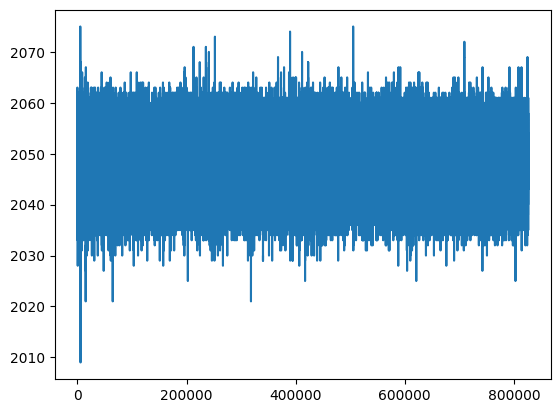

In [5]:
plt.plot(raw_voltages[:, 1])
plt.show()

Plot the raw traces.

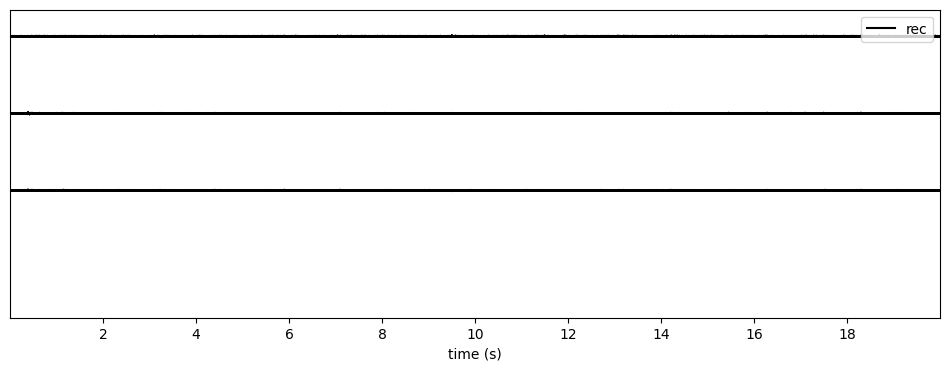

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
si.plot_traces(RX, time_range=[0,20], ax=ax, channel_ids=chans, color='k')

## Pre-processing
---

In [10]:
RX_filtered = st.BlankSaturationRecording(RX, quantile_threshold=0.1)
RX_filtered
# # RX_filtered = st.normalize_by_quantile(RX_filtered, scale=20)

BlankSaturationRecording: 4096 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                          150.00s (2.50 minutes) - uint16 dtype - 15.76 GiB

Bandpass filter.

In [11]:
RX_filtered_bpass = si.bandpass_filter(RX_filtered, freq_min=300, freq_max=3000)
RX_filtered_bpass

BandpassFilterRecording: 4096 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                         150.00s (2.50 minutes) - int16 dtype - 15.76 GiB

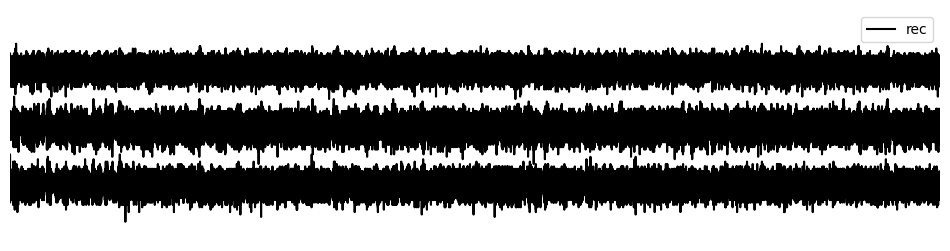

In [12]:
# next we plot some raw data traces
# for better visualisation, we bandpass filter the traces before showing them
# to this end, we use a lazy bandpass filter from spiketoolkit
plt.figure(figsize=(12,3))
ax = plt.subplot(111)
w = si.plot_timeseries(RX_filtered_bpass, channel_ids=['2', '3', '4'], color='k', ax=ax, time_range=[0, 10])
ax.plot((2.01,2.11),(-50,-50),'k-');
ax.annotate('100ms',(2.051,-120), ha='center');
ax.axis('off');

Remove bad channels.

In [13]:
chans2keep = ['2825','2826','2827', '2828', '2829', '2830', '2831', '2832', '2833', '2834', '2835', '2836', '2837', '2838', '2840', '2841', '2842', '2843', '2844', '2845']

In [14]:
rec_clean = RX_filtered_bpass.select_channels(chans2keep)

In [15]:
# # detect
# bad_channel_ids, channel_labels = st.detect_bad_channels(recording=RX_filtered_bpass)
# rec_clean = RX_filtered_bpass.remove_channels(remove_channel_ids=bad_channel_ids)

# print(f'Bad channels: {bad_channel_ids}')

In [18]:
rec_clean

ChannelSliceRecording: 20 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                       150.00s (2.50 minutes) - int16 dtype - 78.81 MiB

Common median reference.

In [19]:
recording_cmr = st.common_reference(recording=rec_clean, operator="median")

Normalize the recordings. Apply the gains and offsets.

In [20]:
# rec_normed = st.zscore(recording=recording_cmr)

Bandpass filter and re-plot the data.

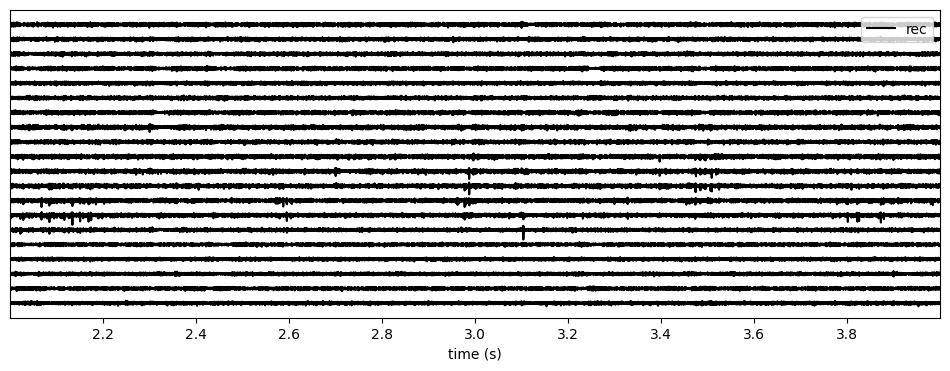

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
si.plot_traces(recording_cmr, time_range=[2,4], ax=ax)

## Spike-sorting
-----

First, check the available sorters.

In [22]:
import spikeinterface.sorters as ss
ss.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'kilosort4',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'simple',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

Set the default sorting parameters.

In [23]:
sorter_params = si.get_default_sorter_params('kilosort2')
sorter_params

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'whiteningRange': 32,
 'momentum': [20.0, 400.0],
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'freq_min': 150,
 'sigmaMask': 30,
 'lam': 10.0,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'AUCsplit': 0.9,
 'wave_length': 61,
 'keep_good_only': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None,
 'save_rez_to_mat': False,
 'delete_tmp_files': ('matlab_files',),
 'delete_recording_dat': False,
 'n_jobs': 1,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_process': 1}

In [24]:
# loading kwargs
n_cpus = os.cpu_count()
n_jobs = n_cpus - 4
sorter_params['n_jobs'] = n_jobs

# create an object, passing the recording extractor
hs = si.run_sorter(sorter_name='kilosort2', recording=recording_cmr, output_folder='data/hs_output', docker_image=True, verbose=True, **sorter_params)

print(f'KS3 found: {hs.get_num_units()} units')

C:\Users\michael.zabolocki\AppData\Local\Temp\ipykernel_29644\333719920.py:7: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  hs = si.run_sorter(sorter_name='kilosort2', recording=recording_cmr, output_folder='data/hs_output', docker_image=True, verbose=True, **sorter_params)


installation_mode='auto' switching to installation_mode: 'github'
Starting container
Installing spikeinterface with github in container
Installing neo with pypi in container
Running kilosort2 sorter inside spikeinterface/kilosort2-compiled-base
Stopping container
KS3 found: 11 units


In [25]:
hs = hs.remove_empty_units()
print(f'KS3 found {len(hs.get_unit_ids())} non-empty units')

KS3 found 11 non-empty units


Extract waveforms.

In [26]:
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)
we = si.extract_waveforms(recording_cmr, hs, folder="data/waveforms_sparse", sparse=False, overwrite=None, **job_kwargs)

####
# extract_waveforms() and WaveformExtractor() have been replaced by the `SortingAnalyzer` since version 0.101.0.
# You should use `spikeinterface.create_sorting_analyzer()` instead.
# `spikeinterface.extract_waveforms()` is now mocking the old behavior for backwards compatibility only,
# and will be removed with version 0.103.0
####


c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\core\sortinganalyzer.py:246: UserWarning: Sorting and Recording have a small difference in sampling frequency. This could be due to rounding of floats. Using the sampling frequency from the Recording.
  warnings.warn(


compute_waveforms:   0%|          | 0/151 [00:00<?, ?it/s]

c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


In [28]:
for unit in hs.get_unit_ids():
    waveforms = we.get_waveforms(unit_id=unit)
    spiketrain = hs.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 1 - num waveforms: 93 - num spikes: 93
Unit 2 - num waveforms: 373 - num spikes: 373
Unit 3 - num waveforms: 500 - num spikes: 955
Unit 4 - num waveforms: 66 - num spikes: 66
Unit 6 - num waveforms: 78 - num spikes: 78
Unit 7 - num waveforms: 500 - num spikes: 803
Unit 8 - num waveforms: 36 - num spikes: 36
Unit 9 - num waveforms: 112 - num spikes: 112
Unit 10 - num waveforms: 46 - num spikes: 46
Unit 11 - num waveforms: 17 - num spikes: 17
Unit 12 - num waveforms: 16 - num spikes: 16


Automatic unit removals.

In [29]:
import spikeinterface.qualitymetrics as sqm
qm = sqm.compute_quality_metrics(we, verbose=False, n_jobs=n_jobs)

c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:902: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:745: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1483: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(


Set quality control metrics.

In [30]:
isi_viol_thresh = 0.01  # <= 1% ISI violations of total spikes
firing_rate_thresh = 0.5
snr_thresh = 5
presence_ratio_cutoff = 0.8

In [31]:
qc_query = f"isi_violations_count/num_spikes <= {isi_viol_thresh} & firing_rate > {firing_rate_thresh} & snr >= {snr_thresh} & presence_ratio >= {presence_ratio_cutoff}"

# query for units that pass quality metrics
keep_units = qm.query(qc_query)
keep_unit_ids = keep_units.index.values

print(f"Units that pass quality metrics: {keep_unit_ids}")

# select units that pass quality metrics
# in sorting extractor
sorting_postqc = hs.select_units(keep_unit_ids)

we_postqc = we.select_units(keep_unit_ids)
we_postqc

Units that pass quality metrics: [1 2 3 6 7 9]


SortingAnalyzer: 20 channels - 6 units - 1 segments - memory - has recording
Loaded 5 extensions: random_spikes, waveforms, templates, noise_levels, quality_metrics

Isolate the template metrics.

In [32]:
metric_names = si.get_quality_metric_list()
qm_params = si.get_default_qm_params()
qm = si.compute_quality_metrics(we_postqc, metric_names=metric_names, verbose=True, qm_params=qm_params, **job_kwargs)
qm

Computing amplitude_cutoff
Computing amplitude_cv
Computing amplitude_median
Computing drift
Computing firing_range
Computing firing_rate
Computing isi_violation
Computing num_spikes
Computing presence_ratio
Computing rp_violation
Computing sd_ratio
Computing sliding_rp_violation
Computing snr
Computing synchrony


c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:902: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:745: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1041: UserWarning: The drift metrics require the `spike_locations` waveform extension. Use the `postprocessing.compute_spike_locations()` function. Drift metrics will be set to NaN
  warnings.warn(
c:\Users\michael.zabolocki\Documents\code\3brain_gradelab

,amplitude_cutoff,amplitude_cv,amplitude_median,drift_ptp,drift_std,drift_mad,firing_range,firing_rate,isi_violations_ratio,isi_violations_count,num_spikes,presence_ratio,rp_contamination,rp_violations,sd_ratio,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8
1,NaN,NaN,-58.608059,NaN,NaN,NaN,1.53,0.620000,0.000000,0,93,1.0,0.0,0,NaN,NaN,5.428554,0.000000,0.0,0.0
2,NaN,NaN,-85.958488,NaN,NaN,NaN,4.91,2.486666,0.000000,0,373,1.0,0.0,0,NaN,NaN,14.648915,0.002681,0.0,0.0
3,0.001402,NaN,-113.308914,NaN,NaN,NaN,6.15,6.366666,0.109646,2,955,1.0,0.0,0,NaN,0.13,9.645212,0.002094,0.0,0.0
6,NaN,NaN,-78.144081,NaN,NaN,NaN,0.91,0.520000,0.000000,0,78,1.0,0.0,0,NaN,NaN,7.354533,0.012821,0.0,0.0
7,0.003773,NaN,-74.236877,NaN,NaN,NaN,3.64,5.353333,0.077542,1,803,1.0,0.0,0,NaN,0.18,6.599211,0.002491,0.0,0.0
9,NaN,NaN,-62.515263,NaN,NaN,NaN,1.51,0.746667,0.000000,0,112,1.0,0.0,0,NaN,NaN,5.407960,0.000000,0.0,0.0


Check the rasterplot.

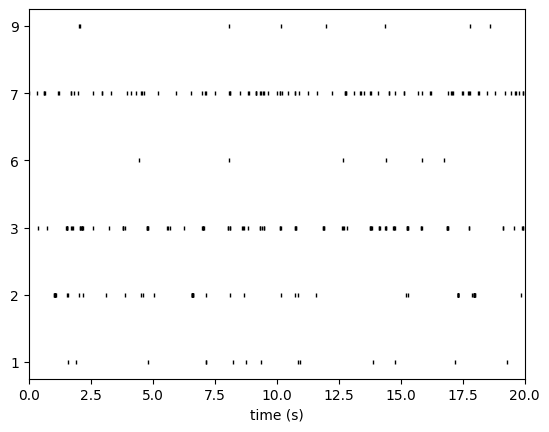

In [33]:
w_rs = si.plot_rasters(sorting_postqc, time_range=(0, 20), backend="matplotlib")

## Export to Phy
----

Use Phy2 for manual curations.

In [34]:
si.export_to_phy(we_postqc, output_folder= 'data/phy_KS2', 
                 compute_amplitudes=True, compute_pc_features=True, copy_binary=True,
                 **job_kwargs)

write_binary_recording:   0%|          | 0/151 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/151 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/6 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/6 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/151 [00:00<?, ?it/s]

Run:
phy template-gui  C:\Users\michael.zabolocki\Documents\code\3brain_gradelab\data\phy_KS2\params.py


## Export a report to Phy
-----

In [38]:
from spikeinterface import create_sorting_analyzer, load_sorting_analyzer

In [39]:
analyzer = create_sorting_analyzer(sorting=hs,
                                   recording=recording_cmr,
                                   format="binary_folder",
                                   return_scaled=True, # this is the default to attempt to return scaled
                                   folder= "data/analyzer_folder"
                                   )

c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


estimate_sparsity:   0%|          | 0/151 [00:00<?, ?it/s]

c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\core\sortinganalyzer.py:246: UserWarning: Sorting and Recording have a small difference in sampling frequency. This could be due to rounding of floats. Using the sampling frequency from the Recording.
  warnings.warn(


Compute waveforms.

In [40]:
analyzer.compute(
    "random_spikes",
    method="uniform",
    max_spikes_per_unit=500,
)
analyzer.compute("waveforms", ms_before=1.0, ms_after=2.0)
analyzer.compute("templates", operators=["average", "median", "std"])
print(analyzer)

compute_waveforms:   0%|          | 0/151 [00:00<?, ?it/s]

SortingAnalyzer: 20 channels - 11 units - 1 segments - binary_folder - sparse - has recording
Loaded 3 extensions: random_spikes, waveforms, templates


Generate waveform templates.

In [41]:
analyzer.compute("templates", operators=["average", "median", "std"])

ext_templates = analyzer.get_extension("templates")
av_templates = ext_templates.get_data(operator="average")
print(av_templates.shape)

(11, 40, 20)


Compute waveform features.

In [42]:
# core extensions
analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels", "correlograms"])

# more extensions
analyzer.compute(["spike_amplitudes", "unit_locations", "spike_locations", "template_metrics", "quality_metrics", "template_similarity"])

compute_waveforms:   0%|          | 0/151 [00:00<?, ?it/s]

c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(
c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


Compute : spike_amplitudes + spike_locations:   0%|          | 0/151 [00:00<?, ?it/s]

c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:902: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


Export export report.

In [43]:
si.export_report(analyzer, output_folder= 'data/report_KS2')

c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


Plot the unit locations.

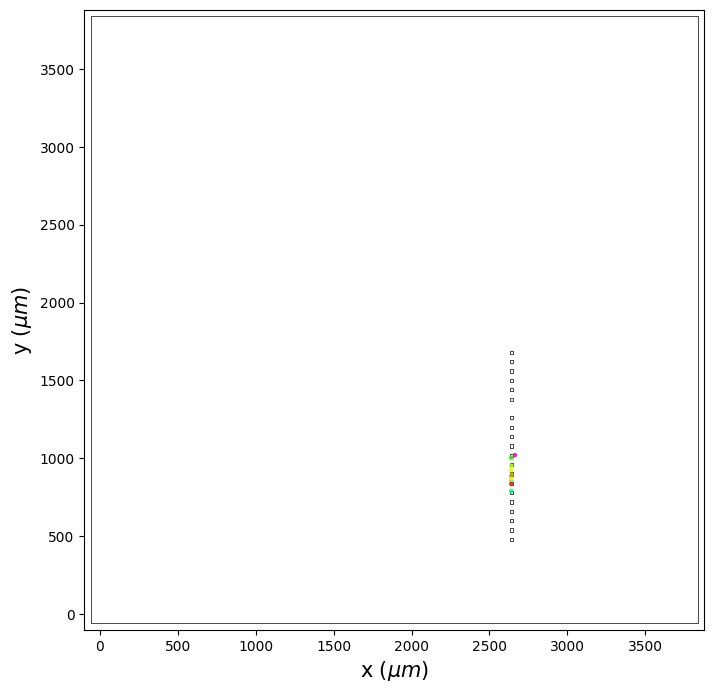

In [44]:
si.plot_unit_locations(analyzer, figsize=(8, 12))

Plot the unit templates.

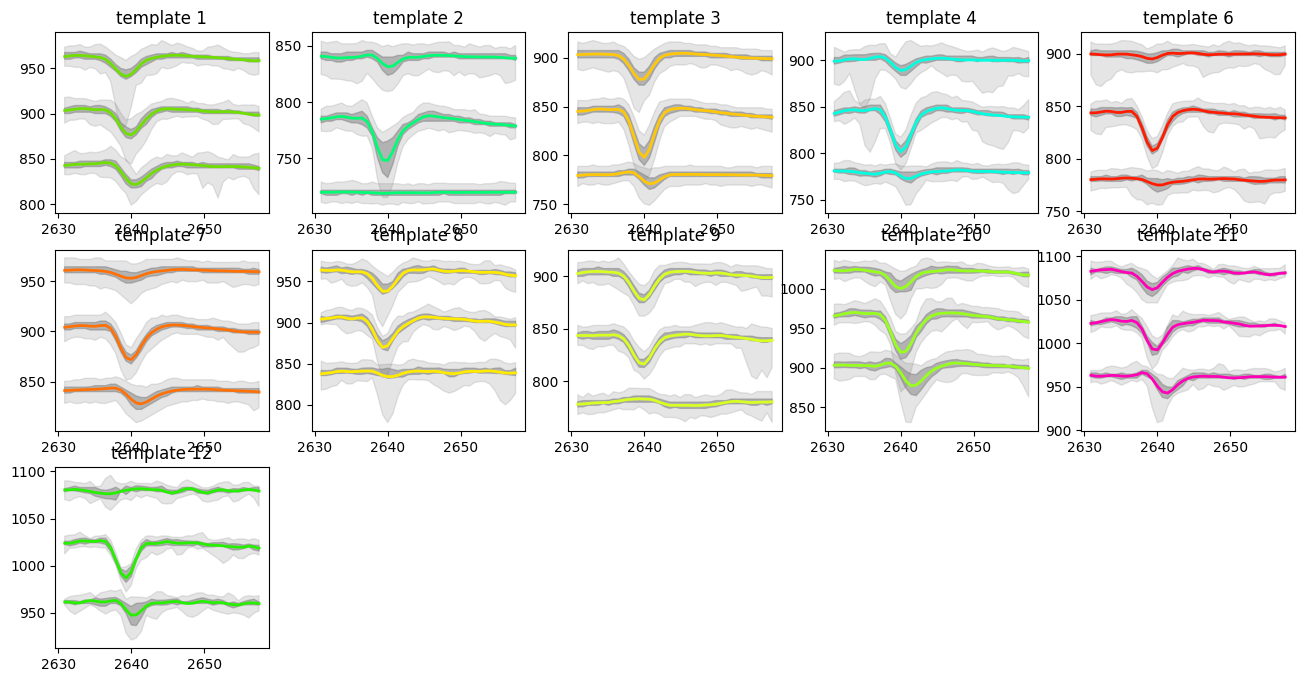

In [45]:
unit_ids = hs.unit_ids
si.plot_unit_templates(analyzer, unit_ids=unit_ids, ncols=5, figsize=(16, 8))